# Fred Burst, Task 1
## Propagate variance from the telluric correction
### Part 4- Progate variance and save everything to an HDF5 file, for K band!

Michael Gully-Santiago  
Wednesday, December 2, 2015  


In the [last notebook](fb001-03_Proagate_Variance_from_Telluric.ipynb), we divided the H-band target spectrum by the telluric spectrum, and saved the H-band spectrum to HDF5.

In this notebook, we do the same thing for the K-band.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('notebook')

## Read in all the data.
No spot-checking necessary, since we already did that in the previous notebook.

In [3]:
hdu_raw = fits.open('../../../KIAA/Science/ASASSN-15qi/data/ASASSN-15qi_reduced/outdata/20151022/SDCK_20151022_0067.spec.fits')
hdu_f   = fits.open('../../../KIAA/Science/ASASSN-15qi/data/ASASSN-15qi_reduced/outdata/20151022/SDCK_20151022_0067.spec_flattened.fits')
hdu_var = fits.open('../../../KIAA/Science/ASASSN-15qi/data/ASASSN-15qi_reduced/outdata/20151022/SDCK_20151022_0067.variance.fits')
hdu_tar = fits.open('../../../KIAA/Science/ASASSN-15qi/data/ASASSN-15qi_reduced/outdata/20151022/SDCK_20151022_0063.spec.fits')
tar_var = fits.open('../../../KIAA/Science/ASASSN-15qi/data/ASASSN-15qi_reduced/outdata/20151022/SDCK_20151022_0063.variance.fits')
hdr = hdu_tar[0].header

## The problem: Propagating uncertainty

We are performing:  
$$ f_{\star} = \frac{f_{raw, \star}}{f_{raw, std}} $$

The net uncertainty is given by:

$$ \sigma_{\star} = f_{\star} \sqrt{ \left( \frac{\sigma_{raw, std}}{f_{raw, std}}\right)^2 + \left( \frac{\sigma_{raw, \star}}{f_{raw,\star}} \right)^2 }$$

In [4]:
f_star = hdu_tar[0].data/hdu_raw[0].data

In [5]:
term1 = hdu_var[0].data / hdu_raw[0].data**2
term2 = tar_var[0].data / hdu_tar[0].data**2
sig_star = f_star * np.sqrt( term1 + term2 )

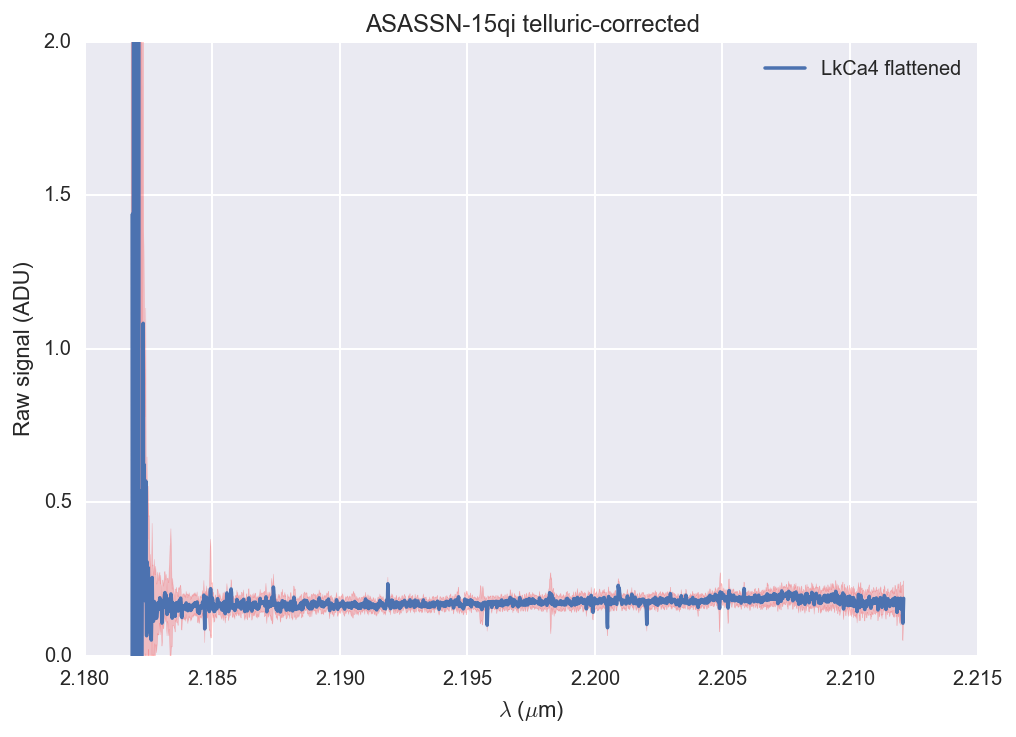

In [6]:
o=10
plt.plot(hdu_tar[1].data[o, :], f_star[o, :], label='LkCa4 flattened')
plt.fill_between(hdu_raw[1].data[o, :], f_star[o, :] - 1.96 * sig_star[o, :], f_star[o, :] + 1.96 * sig_star[o, :],
                alpha=0.2, color='r', label='95% confidence interval')

plt.legend(loc='best')

plt.ylim(ymin=0)
plt.xlabel("$\lambda$ ($\mu$m)")
plt.ylabel("Raw signal (ADU)");
plt.ylim(0, 2)
plt.title('{OBJECT} telluric-corrected'.format(OBJECT=hdr['OBJECT']));


**Figure 1:** Stellar target spectrum corrected for the spectral response function- both instrumental response and telluric absorption lines.  The pink contour shows the 95% confidence interval.

## Save the file format
We want HDF5, actually...

Do some data munging.

In [7]:
wavelength_angstrom = hdu_tar[1].data*10000.0

In [8]:
masks = (f_star != f_star) | ((sig_star != sig_star))

In [9]:
masks.sum()

1146

In [10]:
import h5py

In [11]:
f = h5py.File("../data/reduced/ASASSN15qi_IGRINS_K.hdf5", "w")
dset1 = f.create_dataset('wls', data=wavelength_angstrom) #Angstroms
dset2 = f.create_dataset('fls', data=f_star)
dset3 = f.create_dataset('sigmas', data=sig_star)
dset4 = f.create_dataset('masks', data=masks)
f.close()

### Save a fits also.

In [12]:
hdu_tar.info()

Filename: ../../../KIAA/Science/ASASSN-15qi/data/ASASSN-15qi_reduced/outdata/20151022/SDCK_20151022_0063.spec.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     175   (2048, 25)   float32   
1                ImageHDU        80   (2048, 25)   float64   


In [14]:
tell_cor = fits.hdu.PrimaryHDU(data=f_star)
variance = fits.hdu.PrimaryHDU(data=sig_star)

In [15]:
hdu_tar[1].update_ext_name('WAVELENG')
tell_cor.update_ext_name('TELLCOR')
variance.update_ext_name('SIGMA')

In [16]:
hdu_tar.append(tell_cor)
hdu_tar.append(variance)

In [17]:
hdu_tar.info()

Filename: ../../../KIAA/Science/ASASSN-15qi/data/ASASSN-15qi_reduced/outdata/20151022/SDCK_20151022_0063.spec.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     175   (2048, 25)   float32   
1    WAVELENG    ImageHDU        81   (2048, 25)   float64   
2    TELLCOR     ImageHDU         8   (2048, 25)   float32   
3    SIGMA       ImageHDU         8   (2048, 25)   float32   


In [19]:
hdu_tar.writeto('../data/reduced/ASASSN15qi_IGRINS_K.fits', clobber=True)

## Spot check the telluric correction

Normalize the observed spectrum.

In [ ]:
t_inst = hdu_raw[0].data[o, :] / hdu_f[0].data[o, :] 
t_oplus = hdu_f[0].data[o, :] 

In [ ]:
o=10
x_det = 2.198
plt.figure(figsize=(15, 12))

plt.subplot(231)
tar_f = hdu_tar[0].data[o, :] / t_inst
norm_c = np.nanmedian(tar_f)
plt.plot(hdu_tar[1].data[o, :], tar_f/norm_c, label='Target flattened')
plt.plot(hdu_raw[1].data[o, :], hdu_f[0].data[o, :], label='A0V flattened')
#plt.plot(sub_sample_x, sub_sample_y, label='sub sample')
plt.legend(loc='best')
plt.ylim(0, 2)
plt.xlabel("$\lambda$ ($\mu$m)")
plt.ylabel("Normalized signal");
plt.title('{OBJECT} raw spectrum'.format(OBJECT=hdr['OBJECT']));

plt.subplot(232)
tar_f = hdu_tar[0].data[o, :] / t_inst
plt.plot(hdu_tar[1].data[o, :], tar_f/norm_c, label='Target flattened')
plt.plot(hdu_raw[1].data[o, :], hdu_f[0].data[o, :], label='A0V flattened')
plt.legend(loc='best')
x_c = hdu_raw[1].data[o, 1024]
plt.xlim(x_c-0.005, x_c+0.005)
plt.ylim(0.5, 1.5)
plt.xlabel("$\lambda$ ($\mu$m)")
plt.ylabel("Normalized signal");
plt.title('detail');

plt.subplot(233)
tar_f = hdu_tar[0].data[o, :] / t_inst
plt.step(hdu_tar[1].data[o, :], tar_f/norm_c, label='Target flattened')
plt.step(hdu_raw[1].data[o, :], hdu_f[0].data[o, :], label='A0V flattened')
plt.legend(loc='best')
x_c = x_det
plt.xlim(x_c-0.001, x_c+0.001)
plt.ylim(0.5, 1.5)
plt.xlabel("$\lambda$ ($\mu$m)")
plt.ylabel("Normalized signal");
plt.title('high detail');

plt.subplot(234)
tar_f = hdu_tar[0].data[o, :] / t_inst
plt.plot(hdu_tar[1].data[o, :], tar_f/norm_c, 'k', alpha=0.2, label='Target observed')
plt.plot(hdu_tar[1].data[o, :], tar_f/norm_c/hdu_f[0].data[o, :], label='Target / $\hat t_{\oplus}$')
plt.legend(loc='best')
plt.ylim(0, 1.5)
plt.xlabel("$\lambda$ ($\mu$m)")
plt.ylabel("Normalized signal");
plt.title('{OBJECT} raw spectrum'.format(OBJECT=hdr['OBJECT']));

plt.subplot(235)
tar_f = hdu_tar[0].data[o, :] / t_inst
plt.plot(hdu_tar[1].data[o, :], tar_f/norm_c, 'k', alpha=0.2, label='Target observed')
plt.plot(hdu_tar[1].data[o, :], tar_f/norm_c/hdu_f[0].data[o, :], label='Target flattened')
plt.legend(loc='best')
x_c = hdu_raw[1].data[o, 1024]
plt.xlim(x_c-0.005, x_c+0.005)
plt.ylim(0.5, 1.5)
plt.xlabel("$\lambda$ ($\mu$m)")
plt.ylabel("Normalized signal");
plt.title('detail');

plt.subplot(236)
tar_f = hdu_tar[0].data[o, :] / t_inst
plt.step(hdu_tar[1].data[o, :], tar_f/norm_c, 'k', alpha=0.2, label='Target observed')
plt.step(hdu_tar[1].data[o, :], tar_f/norm_c/hdu_f[0].data[o, :], label='Target flattened')
plt.legend(loc='best')
x_c = x_det
plt.xlim(x_c-0.001, x_c+0.001)
plt.ylim(0.5, 1.5)
plt.xlabel("$\lambda$ ($\mu$m)")
plt.ylabel("Normalized signal");
plt.title('high detail');
plt.savefig('Example_telluric.pdf')

## The end.